<a href="https://colab.research.google.com/github/SanyaKapoor/Online-Signature-Verification/blob/main/Online_Signature_Verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Sanya/DID-AEZ11/Task2/Task2/
!ls

Mounted at /content/drive
/content/drive/MyDrive/Sanya/DID-AEZ11/Task2/Task2
templates   U16S34.TXT	U22S22.TXT  U29S10.TXT	U34S35.TXT  U40S23.TXT
U10S10.TXT  U16S35.TXT	U22S23.TXT  U29S11.TXT	U34S36.TXT  U40S24.TXT
U10S11.TXT  U16S36.TXT	U22S24.TXT  U29S12.TXT	U34S37.TXT  U40S25.TXT
U10S12.TXT  U16S37.TXT	U22S25.TXT  U29S13.TXT	U34S38.TXT  U40S26.TXT
U10S13.TXT  U16S38.TXT	U22S26.TXT  U29S14.TXT	U34S39.TXT  U40S27.TXT
U10S14.TXT  U16S39.TXT	U22S27.TXT  U29S15.TXT	U34S3.TXT   U40S28.TXT
U10S15.TXT  U16S3.TXT	U22S28.TXT  U29S16.TXT	U34S40.TXT  U40S29.TXT
U10S16.TXT  U16S40.TXT	U22S29.TXT  U29S17.TXT	U34S4.TXT   U40S2.TXT
U10S17.TXT  U16S4.TXT	U22S2.TXT   U29S18.TXT	U34S5.TXT   U40S30.TXT
U10S18.TXT  U16S5.TXT	U22S30.TXT  U29S19.TXT	U34S6.TXT   U40S31.TXT
U10S19.TXT  U16S6.TXT	U22S31.TXT  U29S1.TXT	U34S7.TXT   U40S32.TXT
U10S1.TXT   U16S7.TXT	U22S32.TXT  U29S20.TXT	U34S8.TXT   U40S33.TXT
U10S20.TXT  U16S8.TXT	U22S33.TXT  U29S21.TXT	U34S9.TXT   U40S34.TXT
U10S21.TXT  U16S9.TXT	U22S34.TXT  

Visualizing histograms for genuine signature (User 1, Signature 5)


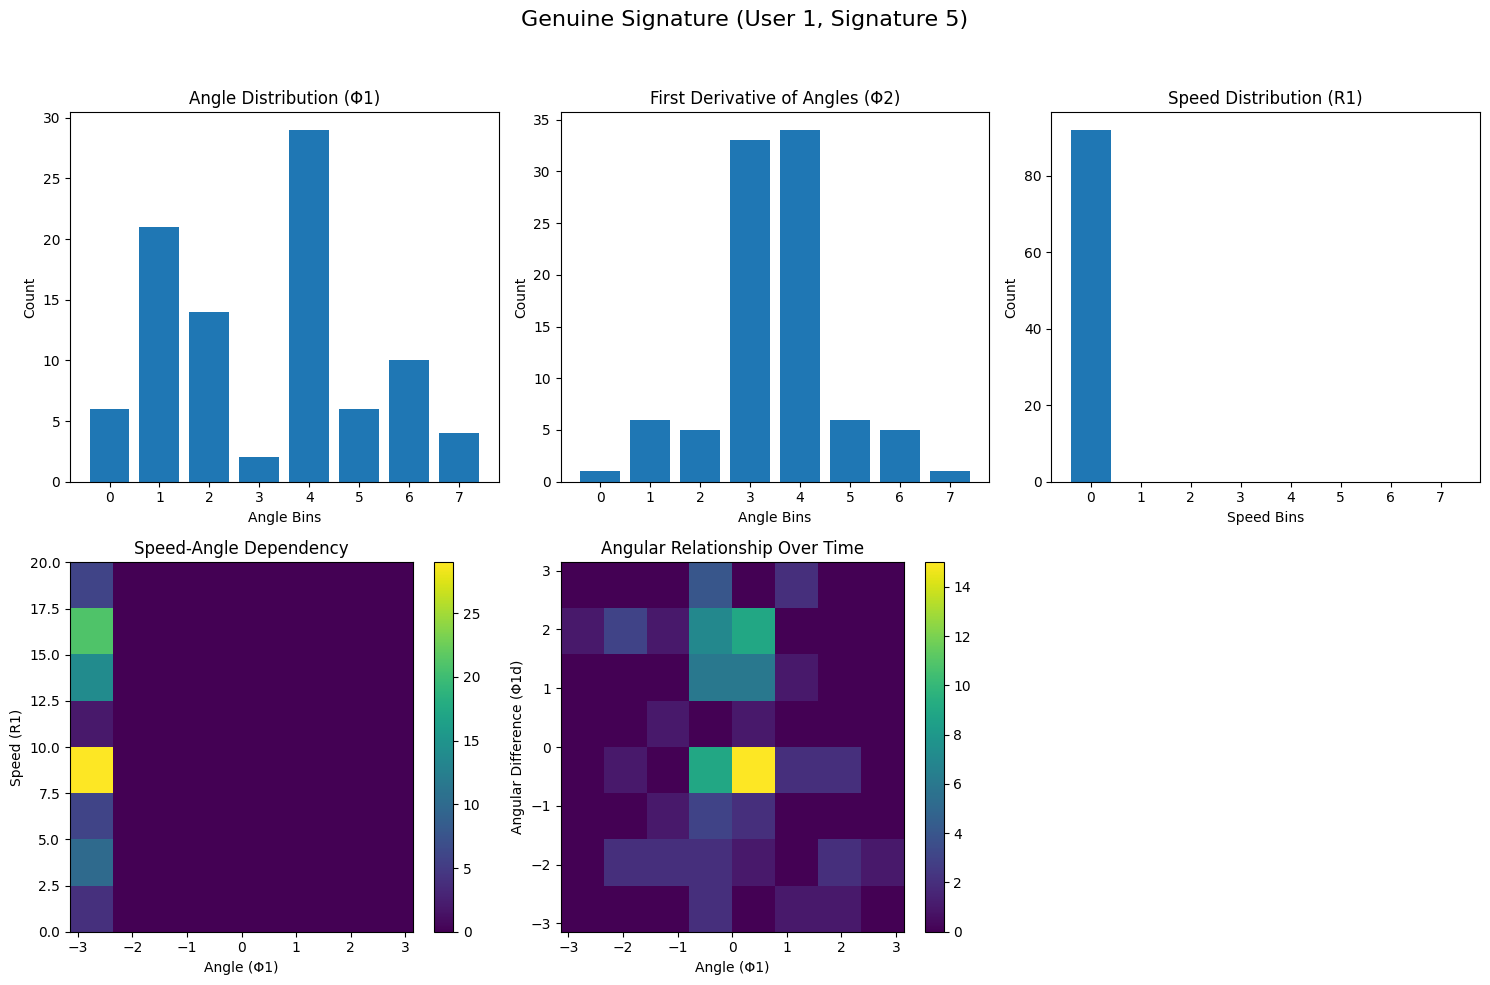

Visualizing histograms for forged signature (User 1, Signature 25)


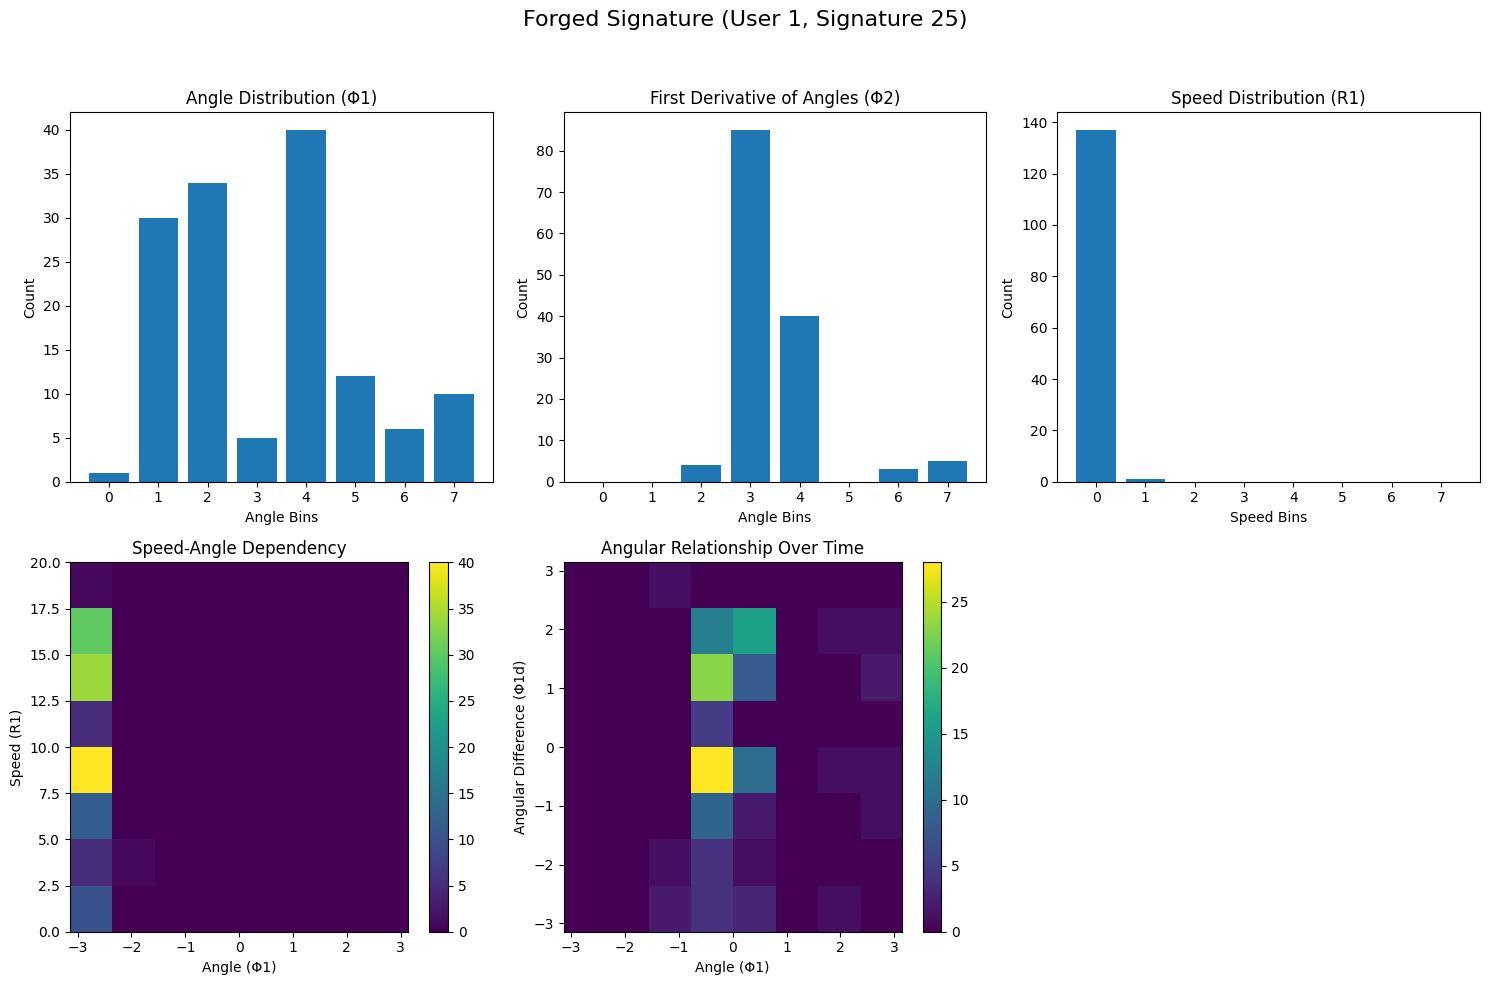

Distance between genuine and forged: 7214.0
Distance between two genuine signatures: 617.0
Verification system correctly identified the forgery.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

class SignatureFeatureExtractor:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        #histogram parameters
        self.angle_bins = np.linspace(-np.pi, np.pi, 9)  # 8 bins for angles
        self.speed_bins = np.linspace(0, 20, 9)  # 8 bins for speed, max value depends on data

    def load_signature(self, user_id, signature_id):
        filename = f"U{user_id}S{signature_id}.TXT"
        filepath = os.path.join(self.data_dir, filename)

        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Signature file {filepath} not found")

        with open(filepath, 'r') as f:
            lines = f.readlines()

        n_points = int(lines[0].strip())
        points = []

        for i in range(1, n_points + 1):
            if i >= len(lines):
                break

            values = lines[i].strip().split()
            point = {}

            # Add features based on availability
            point['x'] = float(values[0])
            point['y'] = float(values[1])

            if len(values) > 2:
                point['timestamp'] = float(values[2])

            if len(values) > 3:
                point['button'] = int(values[3])

            if len(values) > 4:
                point['azimuth'] = float(values[4])

            if len(values) > 5:
                point['altitude'] = float(values[5])

            if len(values) > 6:
                point['pressure'] = float(values[6])
            else:
                point['pressure'] = 0  # Default pressure if not available

            points.append(point)

        signature = {
            'user_id': user_id,
            'signature_id': signature_id,
            'is_genuine': signature_id <= 20,
            'points': points,
            'n_points': len(points)
        }

        return signature

    def compute_derivatives(self, values, order=1):
        if order == 0:
            return values

        if len(values) <= order:
            return []

        if order == 1:
            return [values[i+1] - values[i] for i in range(len(values) - 1)]
        else:
            prev_derivatives = self.compute_derivatives(values, order - 1)
            return self.compute_derivatives(prev_derivatives, 1)

    def extract_features(self, signature, max_derivative_order=2):
        points = signature['points']
        n = len(points)

        # Extract basic sequences
        X = [p['x'] for p in points]
        Y = [p['y'] for p in points]
        P = [p.get('pressure', 0) for p in points]

        features = {'X': X, 'Y': Y, 'P': P}

        #Adding this to fix FRR...
        X_mean, Y_mean = np.mean(X), np.mean(Y)
        X_std, Y_std = np.std(X) or 1, np.std(Y) or 1

        X_norm = [(x - X_mean) / X_std for x in X]
        Y_norm = [(y - Y_mean) / Y_std for y in Y]

        features['X'] = X_norm
        features['Y'] = Y_norm

        # Compute derivatives
        for k in range(1, max_derivative_order + 1):
            features[f'X{k}'] = self.compute_derivatives(X, k)
            features[f'Y{k}'] = self.compute_derivatives(Y, k)
            features[f'P{k}'] = self.compute_derivatives(P, k)

        # Construct vector sequence V
        V = []
        for k in range(max_derivative_order + 1):
            v_k = []
            X_k = features[f'X{k}'] if k > 0 else X[:-1]
            Y_k = features[f'Y{k}'] if k > 0 else Y[:-1]
            P_k = features[f'P{k}'] if k > 0 else P[:-1]

            for i in range(len(X_k)):
                # Calculate polar coordinates
                theta = np.arctan2(Y_k[i], X_k[i]) if X_k[i] != 0 else np.sign(Y_k[i]) * np.pi/2
                r = np.sqrt(X_k[i]**2 + Y_k[i]**2)

                v_k.append({
                    'x': X_k[i],
                    'y': Y_k[i],
                    'r': r,
                    'theta': theta,
                    'p': P_k[i] if i < len(P_k) else 0
                })

            V.append(v_k)

        features['V'] = V

        # Compute histograms
        features['histograms'] = self.compute_histograms(features)

        return features

    def compute_histograms(self, features):
        histograms = {}

        # 1. Angle Distribution (Φ1)
        phi1 = []
        for i in range(len(features['X']) - 1):
            dx = features['X'][i+1] - features['X'][i]
            dy = features['Y'][i+1] - features['Y'][i]
            angle = np.arctan2(dy, dx)
            phi1.append(angle)

        histograms['phi1'] = np.histogram(phi1, bins=self.angle_bins)[0]

        # 2. First Derivative of Angles (Φ2)
        phi2 = []
        for i in range(len(phi1) - 1):
            phi2.append(phi1[i+1] - phi1[i])

        # Normalize angles to [-π, π]
        phi2 = [(angle + np.pi) % (2 * np.pi) - np.pi for angle in phi2]
        histograms['phi2'] = np.histogram(phi2, bins=self.angle_bins)[0]

        # 3. Speed Distribution (R1)
        r1 = []
        for i in range(len(features['X']) - 1):
            dx = features['X'][i+1] - features['X'][i]
            dy = features['Y'][i+1] - features['Y'][i]
            speed = np.sqrt(dx**2 + dy**2)
            r1.append(speed)

        histograms['r1'] = np.histogram(r1, bins=self.speed_bins)[0]

        # 4. Speed-Angle Dependency (2D histogram)
        hist_speed_angle, _, _ = np.histogram2d(
            phi1, r1,
            bins=[self.angle_bins, self.speed_bins]
        )
        histograms['speed_angle'] = hist_speed_angle

        # 5. Angular Relationship Over Time
        phi1_d = []
        for i in range(len(phi1) - 1):
            phi1_d.append(phi1[i+1] - phi1[i])

        # Normalize angles to [-π, π]
        phi1_d = [(angle + np.pi) % (2 * np.pi) - np.pi for angle in phi1_d]

        phi1_d12 = []
        for i in range(len(phi1_d) - 1):
            phi1_d12.append(phi1_d[i+1] - phi1_d[i])

        # Normalize angles to [-π, π]
        phi1_d12 = [(angle + np.pi) % (2 * np.pi) - np.pi for angle in phi1_d12]

        # Only compute if there are enough points
        if len(phi1) > 2 and len(phi1_d) > 0:
            hist_angular_time, _, _ = np.histogram2d(
                phi1[:-1], phi1_d,
                bins=[self.angle_bins, self.angle_bins]
            )
            histograms['angular_time'] = hist_angular_time
        else:
            histograms['angular_time'] = np.zeros((len(self.angle_bins)-1, len(self.angle_bins)-1))

        return histograms

    def visualize_histograms(self, histograms, title="Signature Histograms"):
        fig = plt.figure(figsize=(15, 10))
        plt.suptitle(title, fontsize=16)

        # 1D histograms
        ax1 = fig.add_subplot(2, 3, 1)
        ax1.bar(range(len(histograms['phi1'])), histograms['phi1'])
        ax1.set_title('Angle Distribution (Φ1)')
        ax1.set_xlabel('Angle Bins')
        ax1.set_ylabel('Count')

        ax2 = fig.add_subplot(2, 3, 2)
        ax2.bar(range(len(histograms['phi2'])), histograms['phi2'])
        ax2.set_title('First Derivative of Angles (Φ2)')
        ax2.set_xlabel('Angle Bins')
        ax2.set_ylabel('Count')

        ax3 = fig.add_subplot(2, 3, 3)
        ax3.bar(range(len(histograms['r1'])), histograms['r1'])
        ax3.set_title('Speed Distribution (R1)')
        ax3.set_xlabel('Speed Bins')
        ax3.set_ylabel('Count')

        # 2D histograms
        ax4 = fig.add_subplot(2, 3, 4)
        im = ax4.imshow(histograms['speed_angle'], cmap='viridis', aspect='auto',
                       extent=[self.angle_bins[0], self.angle_bins[-1],
                               self.speed_bins[0], self.speed_bins[-1]])
        ax4.set_title('Speed-Angle Dependency')
        ax4.set_xlabel('Angle (Φ1)')
        ax4.set_ylabel('Speed (R1)')
        plt.colorbar(im, ax=ax4)

        ax5 = fig.add_subplot(2, 3, 5)
        im = ax5.imshow(histograms['angular_time'], cmap='viridis', aspect='auto',
                       extent=[self.angle_bins[0], self.angle_bins[-1],
                               self.angle_bins[0], self.angle_bins[-1]])
        ax5.set_title('Angular Relationship Over Time')
        ax5.set_xlabel('Angle (Φ1)')
        ax5.set_ylabel('Angular Difference (Φ1d)')
        plt.colorbar(im, ax=ax5)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    def compare_signatures(self, sig1_features, sig2_features):
        hist1 = sig1_features['histograms']
        hist2 = sig2_features['histograms']

        # Calculate distances for 1D histograms
        dist_phi1 = np.sum((hist1['phi1'] - hist2['phi1'])**2)
        dist_phi2 = np.sum((hist1['phi2'] - hist2['phi2'])**2)
        dist_r1 = np.sum((hist1['r1'] - hist2['r1'])**2)

        # Calculate distances for 2D histograms
        dist_speed_angle = np.sum((hist1['speed_angle'] - hist2['speed_angle'])**2)
        dist_angular_time = np.sum((hist1['angular_time'] - hist2['angular_time'])**2)

        # Weighted combination
        total_dist = (dist_phi1 + dist_phi2 + dist_r1 +
                      dist_speed_angle + dist_angular_time)

        return total_dist

def main():
    data_dir = "/content/drive/MyDrive/Sanya/DID-AEZ11/Task2/Task2/"
    extractor = SignatureFeatureExtractor(data_dir)
    try:
        user_id = 1
        genuine_id = 5  # Genuine signature (1-20)
        forgery_id = 25  # Forgery signature (21-40)

        # Load signatures
        genuine_sig = extractor.load_signature(user_id, genuine_id)
        forgery_sig = extractor.load_signature(user_id, forgery_id)
        another_genuine_sig = extractor.load_signature(user_id, genuine_id + 1)

        # Extract features
        genuine_features = extractor.extract_features(genuine_sig)
        forgery_features = extractor.extract_features(forgery_sig)
        another_genuine_features = extractor.extract_features(another_genuine_sig)

        # Visualize histograms
        print(f"Visualizing histograms for genuine signature (User {user_id}, Signature {genuine_id})")
        extractor.visualize_histograms(genuine_features['histograms'],
                                     f"Genuine Signature (User {user_id}, Signature {genuine_id})")

        print(f"Visualizing histograms for forged signature (User {user_id}, Signature {forgery_id})")
        extractor.visualize_histograms(forgery_features['histograms'],
                                     f"Forged Signature (User {user_id}, Signature {forgery_id})")

        # Compare signatures
        genuine_vs_forgery = extractor.compare_signatures(genuine_features, forgery_features)
        genuine_vs_genuine = extractor.compare_signatures(genuine_features, another_genuine_features)

        print(f"Distance between genuine and forged: {genuine_vs_forgery}")
        print(f"Distance between two genuine signatures: {genuine_vs_genuine}")

        if genuine_vs_genuine < genuine_vs_forgery:
            print("Verification system correctly identified the forgery.")
        else:
            print("Verification system failed to distinguish the forgery.")

    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please ensure the signature data directory is correctly specified.")

        # Create a demo with random data if files not found
        print("\nCreating a demo with random data...")

        # Generate random signature data
        def create_random_signature(n_points=100):
            points = []
            x, y = 0, 0
            for i in range(n_points):
                x += np.random.normal(0, 0.5)
                y += np.random.normal(0, 0.5)
                points.append({
                    'x': x,
                    'y': y,
                    'pressure': np.random.random()
                })
            return {
                'user_id': 0,
                'signature_id': 0,
                'is_genuine': True,
                'points': points,
                'n_points': n_points
            }

        # Create random signatures
        genuine_sig = create_random_signature(100)
        forgery_sig = create_random_signature(90)  # Forgery with different number of points
        another_genuine_sig = create_random_signature(105)  # Similar genuine with different number of points

        # Extract features
        genuine_features = extractor.extract_features(genuine_sig)
        forgery_features = extractor.extract_features(forgery_sig)
        another_genuine_features = extractor.extract_features(another_genuine_sig)

        # Visualize histograms
        print("Visualizing histograms for demo genuine signature")
        extractor.visualize_histograms(genuine_features['histograms'], "Demo Genuine Signature")

        print("Visualizing histograms for demo forged signature")
        extractor.visualize_histograms(forgery_features['histograms'], "Demo Forged Signature")

        # Compare signatures
        genuine_vs_forgery = extractor.compare_signatures(genuine_features, forgery_features)
        genuine_vs_genuine = extractor.compare_signatures(genuine_features, another_genuine_features)

        print(f"Distance between genuine and forged: {genuine_vs_forgery}")
        print(f"Distance between two genuine signatures: {genuine_vs_genuine}")

if __name__ == "__main__":
    main()

Generating template for User 1...
Template saved to templates/user_1_template.pkl
Genuine signature U1S11: Score = 111111237.8181
Genuine signature U1S12: Score = 6428571588.6633
Genuine signature U1S13: Score = 2380952526.1695
Genuine signature U1S14: Score = 6176470736.4964
Genuine signature U1S15: Score = 20454545606.7535
Genuine signature U1S16: Score = 5555555695.4163
Genuine signature U1S17: Score = 13316326715.1816
Genuine signature U1S18: Score = 9257561307.4740
Genuine signature U1S19: Score = 14948979778.1949
Genuine signature U1S20: Score = 4661145341.4646
Forgery signature U1S21: Score = 24031250266.0473
Forgery signature U1S22: Score = 20839130670.6825
Forgery signature U1S23: Score = 50296783448.5650
Forgery signature U1S24: Score = 20394003138.4592
Forgery signature U1S25: Score = 21973189964.4215
Forgery signature U1S26: Score = 26970159863.2429
Forgery signature U1S27: Score = 14911809392.8786
Forgery signature U1S28: Score = 10613488828.6529
Forgery signature U1S29: S

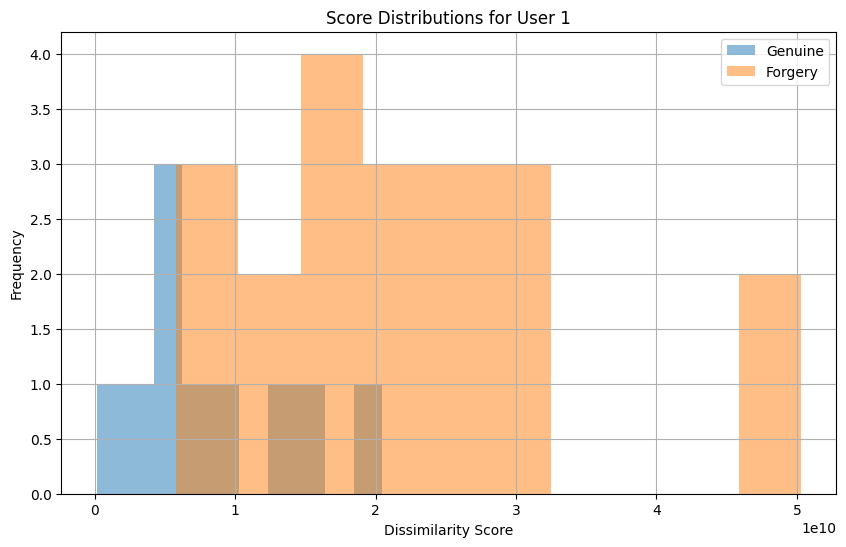

Optimal threshold: 8041378803.4388 (Accuracy: 83.33%)
False Acceptance Rate (FAR): 10.00%
False Rejection Rate (FRR): 40.00%
Equal Error Rate (EER) approximately: 25.00%


In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
import pickle
import time

class SignatureTemplateGenerator:
    def __init__(self, extractor, beta=1.5, abs_epsilon=0.002, rel_epsilon=0.8):
        self.extractor = extractor
        self.beta = beta
        self.abs_epsilon = abs_epsilon
        self.rel_epsilon = rel_epsilon

    def _get_epsilon(self, histogram_type):
        return self.abs_epsilon if histogram_type == 'abs' else self.rel_epsilon

    def _flatten_histogram(self, hist_dict):
        # Determine which histograms to use based on Table 1 in the document
        feature_vector = []

        # 1. Phi1 (Relative frequency)
        feature_vector.extend(hist_dict['phi1'] / np.sum(hist_dict['phi1']) if np.sum(hist_dict['phi1']) > 0 else hist_dict['phi1'])

        # 2. Phi2 (Relative frequency)
        feature_vector.extend(hist_dict['phi2'] / np.sum(hist_dict['phi2']) if np.sum(hist_dict['phi2']) > 0 else hist_dict['phi2'])

        # 3. <Phi1, Phi1d(1,2)> (Absolute frequency)
        feature_vector.extend(hist_dict['angular_time'].flatten())

        # 4. R1 (Absolute frequency)
        feature_vector.extend(hist_dict['r1'])

        # 5. R2 (Absolute frequency) - We need to compute this from R1 derivatives
        if 'r2' in hist_dict:
            feature_vector.extend(hist_dict['r2'])

        # 6-9. X1, Y1, X2, Y2 (Relative frequency)
        for key in ['x1', 'y1', 'x2', 'y2']:
            if key in hist_dict:
                hist = hist_dict[key]
                feature_vector.extend(hist / np.sum(hist) if np.sum(hist) > 0 else hist)

        # 10-11. <X1, X2>, <Y1, Y2> (Relative frequency)
        for key in ['x1x2', 'y1y2']:
            if key in hist_dict:
                hist = hist_dict[key]
                feature_vector.extend(hist.flatten() / np.sum(hist) if np.sum(hist) > 0 else hist.flatten())

        # 12-14. <Phi1, R1>, <Phi2, R2>, <Phi1, R2> (Relative frequency)
        # Split into first and second half
        if 'speed_angle' in hist_dict:
            rows, cols = hist_dict['speed_angle'].shape
            first_half = hist_dict['speed_angle'][:, :cols//2]
            second_half = hist_dict['speed_angle'][:, cols//2:]

            # Normalize if sum > 0
            first_half_norm = first_half / np.sum(first_half) if np.sum(first_half) > 0 else first_half
            second_half_norm = second_half / np.sum(second_half) if np.sum(second_half) > 0 else second_half

            feature_vector.extend(first_half_norm.flatten())
            feature_vector.extend(second_half_norm.flatten())

        # Similar for <Phi2, R2> and <Phi1, R2> if available
        for key in ['phi2_r2', 'phi1_r2']:
            if key in hist_dict:
                rows, cols = hist_dict[key].shape
                first_half = hist_dict[key][:, :cols//2]
                second_half = hist_dict[key][:, cols//2:]

                first_half_norm = first_half / np.sum(first_half) if np.sum(first_half) > 0 else first_half
                second_half_norm = second_half / np.sum(second_half) if np.sum(second_half) > 0 else second_half

                feature_vector.extend(first_half_norm.flatten())
                feature_vector.extend(second_half_norm.flatten())

        # 15-16. P1, P2 (Pressure histograms)
        if 'p1' in hist_dict:
            # Split into first and second half for P1 (Absolute frequency)
            p1 = hist_dict['p1']
            first_half = p1[:len(p1)//2]
            second_half = p1[len(p1)//2:]

            feature_vector.extend(first_half)
            feature_vector.extend(second_half)

        if 'p2' in hist_dict:
            # Split into first and second half for P2 (Relative frequency)
            p2 = hist_dict['p2']
            first_half = p2[:len(p2)//2]
            second_half = p2[len(p2)//2:]

            first_half_norm = first_half / np.sum(first_half) if np.sum(first_half) > 0 else first_half
            second_half_norm = second_half / np.sum(second_half) if np.sum(second_half) > 0 else second_half

            feature_vector.extend(first_half_norm)
            feature_vector.extend(second_half_norm)

        return np.array(feature_vector)

    def extract_extended_histograms(self, features):
        extended_hists = {}

        # Copy the basic histograms
        for key, value in features['histograms'].items():
            extended_hists[key] = value

        # Extract X1, Y1, X2, Y2
        X1 = features.get('X1', [])
        Y1 = features.get('Y1', [])
        X2 = features.get('X2', [])
        Y2 = features.get('Y2', [])

        # Compute mean and std for bounds
        X_mean = np.mean(features['X']) if len(features['X']) > 0 else 0
        X_std = np.std(features['X']) if len(features['X']) > 0 else 1
        Y_mean = np.mean(features['Y']) if len(features['Y']) > 0 else 0
        Y_std = np.std(features['Y']) if len(features['Y']) > 0 else 1

        # Create bins for X and Y derivatives
        X_bins = np.linspace(X_mean - 3*X_std, X_mean + 3*X_std, 9)  # 8 bins
        Y_bins = np.linspace(Y_mean - 3*Y_std, Y_mean + 3*Y_std, 9)  # 8 bins

        # Compute histograms for X1, Y1, X2, Y2
        if len(X1) > 0:
            extended_hists['x1'] = np.histogram(X1, bins=X_bins)[0]
        if len(Y1) > 0:
            extended_hists['y1'] = np.histogram(Y1, bins=Y_bins)[0]
        if len(X2) > 0:
            extended_hists['x2'] = np.histogram(X2, bins=X_bins)[0]
        if len(Y2) > 0:
            extended_hists['y2'] = np.histogram(Y2, bins=Y_bins)[0]

        # Compute 2D histograms for <X1, X2> and <Y1, Y2>
        if len(X1) > 0 and len(X2) > 0:
            min_len = min(len(X1), len(X2))
            hist_x1x2, _, _ = np.histogram2d(
                X1[:min_len], X2[:min_len],
                bins=[X_bins, X_bins]
            )
            extended_hists['x1x2'] = hist_x1x2

        if len(Y1) > 0 and len(Y2) > 0:
            min_len = min(len(Y1), len(Y2))
            hist_y1y2, _, _ = np.histogram2d(
                Y1[:min_len], Y2[:min_len],
                bins=[Y_bins, Y_bins]
            )
            extended_hists['y1y2'] = hist_y1y2

        # Compute R2 (magnitude of second derivative)
        if len(X2) > 0 and len(Y2) > 0:
            R2 = [np.sqrt(X2[i]**2 + Y2[i]**2) for i in range(min(len(X2), len(Y2)))]
            R_mean = np.mean(features['histograms']['r1']) if len(features['histograms']['r1']) > 0 else 0
            R_std = np.std(features['histograms']['r1']) if len(features['histograms']['r1']) > 0 else 1
            R_bins = np.linspace(0, R_mean + 3*R_std, 9)  # 8 bins
            extended_hists['r2'] = np.histogram(R2, bins=R_bins)[0]

            # Compute <Phi2, R2>
            phi2 = features.get('phi2', [])
            if len(phi2) > 0:
                min_len = min(len(phi2), len(R2))
                hist_phi2_r2, _, _ = np.histogram2d(
                    phi2[:min_len], R2[:min_len],
                    bins=[self.extractor.angle_bins, R_bins]
                )
                extended_hists['phi2_r2'] = hist_phi2_r2

            # Compute <Phi1, R2>
            phi1 = []
            for i in range(len(features['X']) - 1):
                dx = features['X'][i+1] - features['X'][i]
                dy = features['Y'][i+1] - features['Y'][i]
                angle = np.arctan2(dy, dx)
                phi1.append(angle)

            if len(phi1) > 0 and len(R2) > 0:
                min_len = min(len(phi1), len(R2))
                hist_phi1_r2, _, _ = np.histogram2d(
                    phi1[:min_len], R2[:min_len],
                    bins=[self.extractor.angle_bins, R_bins]
                )
                extended_hists['phi1_r2'] = hist_phi1_r2

        # Compute pressure histograms
        if 'P' in features and len(features['P']) > 0:
            P = features['P']
            P_mean = np.mean(P)
            P_std = np.std(P) if np.std(P) > 0 else 1

            # P1 bins (absolute frequency)
            P1_bins = np.linspace(0, P_mean + 3*P_std, 9)  # 8 bins
            extended_hists['p1'] = np.histogram(P, bins=P1_bins)[0]

            # P2 bins (relative frequency)
            P2_bins = np.linspace(P_mean - 3*P_std, P_mean + 3*P_std, 9)  # 8 bins
            extended_hists['p2'] = np.histogram(P, bins=P2_bins)[0]

        return extended_hists

    def generate_template(self, user_id, genuine_signature_ids=range(1, 11)):
        # Collect feature vectors from genuine signatures
        feature_vectors = []

        for sig_id in genuine_signature_ids:
            try:
                # Load signature
                signature = self.extractor.load_signature(user_id, sig_id)

                # Extract features
                features = self.extractor.extract_features(signature)

                # Extract extended histograms
                extended_histograms = self.extract_extended_histograms(features)

                # Flatten histograms into a feature vector
                feature_vector = self._flatten_histogram(extended_histograms)

                feature_vectors.append(feature_vector)

            except Exception as e:
                print(f"Error processing signature U{user_id}S{sig_id}: {e}")

        # Convert to numpy array for easier computation
        feature_vectors = np.array(feature_vectors)

        if len(feature_vectors) == 0:
            raise ValueError("No valid feature vectors extracted")

        # Compute mean and standard deviation for each feature
        mu = np.mean(feature_vectors, axis=0)
        sigma = np.std(feature_vectors, axis=0)

        # Compute quantization step size vector
        q_u = self.beta * sigma

        # Replace zeros to avoid division by zero
        q_u[q_u == 0] = 1e-10

        # Quantize feature vectors
        quantized_vectors = []
        for fv in feature_vectors:
            # Determine if each feature is from absolute or relative frequency histogram
            # This is a simplified approach; in practice, you would track this information
            quantized_vector = fv / q_u
            quantized_vectors.append(quantized_vector)

        # Compute template as average of quantized vectors
        template = np.mean(np.array(quantized_vectors), axis=0)

        return template, q_u

    #Causes 100% FRR...
    # def verify_signature(self, test_signature, user_id, template, q_u):
    #     features = self.extractor.extract_features(test_signature)
    #     extended_histograms = self.extract_extended_histograms(features)
    #     feature_vector = self._flatten_histogram(extended_histograms)
    #     quantized_vector = feature_vector / q_u
    #     distance = np.sum(np.abs(quantized_vector - template))
    #     return distance

    def verify_signature(self, test_signature, user_id, template, q_u):
        features = self.extractor.extract_features(test_signature)
        extended_histograms = self.extract_extended_histograms(features)
        feature_vector = self._flatten_histogram(extended_histograms)
        safe_q_u = q_u.copy()
        safe_q_u[safe_q_u == 0] = 1e-10
        quantized_vector = feature_vector / safe_q_u
        distance = np.sum(np.abs(quantized_vector - template))
        return distance

def main():
    data_dir = "/content/drive/MyDrive/Sanya/DID-AEZ11/Task2/Task2/"

    # Create feature extractor
    extractor = SignatureFeatureExtractor(data_dir)

    # Create template generator
    template_generator = SignatureTemplateGenerator(extractor)

    # Define parameters
    user_id = 1
    training_signature_ids = list(range(1, 11))  # First 10 genuine signatures
    validation_signature_ids = list(range(11, 21))  # Remaining 10 genuine signatures
    forgery_signature_ids = list(range(21, 41))  # All forgeries

    # Create directory for storing templates
    os.makedirs("templates", exist_ok=True)

    try:
        # Generate template for user
        print(f"Generating template for User {user_id}...")
        template, q_u = template_generator.generate_template(user_id, training_signature_ids)

        # Save template
        template_path = f"templates/user_{user_id}_template.pkl"
        with open(template_path, 'wb') as f:
            pickle.dump((template, q_u), f)
        print(f"Template saved to {template_path}")

        # Test with genuine signatures
        genuine_scores = []
        for sig_id in validation_signature_ids:
            try:
                signature = extractor.load_signature(user_id, sig_id)
                score = template_generator.verify_signature(signature, user_id, template, q_u)
                genuine_scores.append(score)
                print(f"Genuine signature U{user_id}S{sig_id}: Score = {score:.4f}")
            except Exception as e:
                print(f"Error processing signature U{user_id}S{sig_id}: {e}")

        # Test with forgery signatures
        forgery_scores = []
        for sig_id in forgery_signature_ids:
            try:
                signature = extractor.load_signature(user_id, sig_id)
                score = template_generator.verify_signature(signature, user_id, template, q_u)
                forgery_scores.append(score)
                print(f"Forgery signature U{user_id}S{sig_id}: Score = {score:.4f}")
            except Exception as e:
                print(f"Error processing signature U{user_id}S{sig_id}: {e}")

        # Plot score distributions
        if genuine_scores and forgery_scores:
            plt.figure(figsize=(10, 6))
            plt.hist(genuine_scores, bins=10, alpha=0.5, label='Genuine')
            plt.hist(forgery_scores, bins=10, alpha=0.5, label='Forgery')
            plt.xlabel('Dissimilarity Score')
            plt.ylabel('Frequency')
            plt.title(f'Score Distributions for User {user_id}')
            plt.legend()
            plt.grid(True)
            plt.savefig(f"templates/user_{user_id}_score_distribution.png")
            plt.show()

            all_scores = genuine_scores + forgery_scores
            labels = [1] * len(genuine_scores) + [0] * len(forgery_scores)  # 1 for genuine, 0 for forgery

            best_threshold = 0
            best_accuracy = 0
            for threshold in np.linspace(min(all_scores), max(all_scores), 100):
                # For a valid match, the score should be BELOW the threshold
                predictions = [1 if score <= threshold else 0 for score in all_scores]
                correct = sum(1 for i in range(len(predictions)) if predictions[i] == labels[i])
                accuracy = correct / len(all_scores)

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_threshold = threshold

            # Add a safety margin to the threshold - experiment to decrease FRR...
            best_threshold = best_threshold * 1.2 # Increase threshold by 20%

            print(f"Optimal threshold: {best_threshold:.4f} (Accuracy: {best_accuracy:.2%})")

            # Compute FAR and FRR
            far = sum(1 for score in forgery_scores if score <= best_threshold) / len(forgery_scores)
            frr = sum(1 for score in genuine_scores if score > best_threshold) / len(genuine_scores)

            print(f"False Acceptance Rate (FAR): {far:.2%}")
            print(f"False Rejection Rate (FRR): {frr:.2%}")
            print(f"Equal Error Rate (EER) approximately: {(far + frr) / 2:.2%}")

        else:
            print("Not enough scores to generate distributions.")

    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please ensure the signature data directory is correctly specified.")

        # Create a demo with random data if files not found
        print("\nCreating a demo with random data...")

        # Generate random signature data function (reused from previous code)
        def create_random_signature(n_points=100):
            points = []
            x, y = 0, 0
            for i in range(n_points):
                x += np.random.normal(0, 0.5)
                y += np.random.normal(0, 0.5)
                points.append({
                    'x': x,
                    'y': y,
                    'pressure': np.random.random()
                })
            return {
                'user_id': 0,
                'signature_id': 0,
                'is_genuine': True,
                'points': points,
                'n_points': n_points
            }

        # Create random training set
        training_signatures = [create_random_signature(100) for _ in range(10)]

        # Extract features and generate template
        feature_vectors = []
        for sig in training_signatures:
            features = extractor.extract_features(sig)
            extended_histograms = template_generator.extract_extended_histograms(features)
            feature_vector = template_generator._flatten_histogram(extended_histograms)
            feature_vectors.append(feature_vector)

        feature_vectors = np.array(feature_vectors)
        mu = np.mean(feature_vectors, axis=0)
        sigma = np.std(feature_vectors, axis=0)
        q_u = template_generator.beta * sigma
        q_u[q_u == 0] = 1e-10

        quantized_vectors = [fv / q_u for fv in feature_vectors]
        template = np.mean(np.array(quantized_vectors), axis=0)

        # Test with genuine and forgery signatures
        genuine_scores = []
        forgery_scores = []

        # Test with 10 random genuine signatures
        for _ in range(10):
            genuine_sig = create_random_signature(100)  # Similar to training
            features = extractor.extract_features(genuine_sig)
            extended_histograms = template_generator.extract_extended_histograms(features)
            feature_vector = template_generator._flatten_histogram(extended_histograms)
            quantized_vector = feature_vector / q_u
            score = np.sum(np.abs(quantized_vector - template))
            genuine_scores.append(score)
            print(f"Demo genuine signature: Score = {score:.4f}")

        # Test with 10 random forgery signatures
        for _ in range(10):
            forgery_sig = create_random_signature(80)  # Different number of points
            # Add more variation to make it a forgery
            for point in forgery_sig['points']:
                point['x'] += np.random.normal(0, 1)
                point['y'] += np.random.normal(0, 1)

            features = extractor.extract_features(forgery_sig)
            extended_histograms = template_generator.extract_extended_histograms(features)
            feature_vector = template_generator._flatten_histogram(extended_histograms)
            quantized_vector = feature_vector / q_u
            score = np.sum(np.abs(quantized_vector - template))
            forgery_scores.append(score)
            print(f"Demo forgery signature: Score = {score:.4f}")

        # Plot demo score distributions
        plt.figure(figsize=(10, 6))
        plt.hist(genuine_scores, bins=10, alpha=0.5, label='Genuine')
        plt.hist(forgery_scores, bins=10, alpha=0.5, label='Forgery')
        plt.xlabel('Dissimilarity Score')
        plt.ylabel('Frequency')
        plt.title('Demo Score Distributions')
        plt.legend()
        plt.grid(True)
        plt.savefig("demo_score_distribution.png")
        plt.show()

class SignatureFeatureExtractor:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        # Define histogram parameters
        self.angle_bins = np.linspace(-np.pi, np.pi, 9)  # 8 bins for angles
        self.speed_bins = np.linspace(0, 20, 9)  # 8 bins for speed, max value depends on data

    def load_signature(self, user_id, signature_id):
        filename = f"U{user_id}S{signature_id}.TXT"
        filepath = os.path.join(self.data_dir, filename)

        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Signature file {filepath} not found")

        with open(filepath, 'r') as f:
            lines = f.readlines()

        n_points = int(lines[0].strip())
        points = []

        for i in range(1, n_points + 1):
            if i >= len(lines):
                break

            values = lines[i].strip().split()
            point = {}

            # Add features based on availability
            point['x'] = float(values[0])
            point['y'] = float(values[1])

            if len(values) > 2:
                point['timestamp'] = float(values[2])

            if len(values) > 3:
                point['button'] = int(values[3])

            if len(values) > 4:
                point['azimuth'] = float(values[4])

            if len(values) > 5:
                point['altitude'] = float(values[5])

            if len(values) > 6:
                point['pressure'] = float(values[6])
            else:
                point['pressure'] = 0  # Default pressure if not available

            points.append(point)

        signature = {
            'user_id': user_id,
            'signature_id': signature_id,
            'is_genuine': signature_id <= 20,
            'points': points,
            'n_points': len(points)
        }

        return signature

    def compute_derivatives(self, values, order=1):
        if order == 0:
            return values

        if len(values) <= order:
            return []

        if order == 1:
            return [values[i+1] - values[i] for i in range(len(values) - 1)]
        else:
            prev_derivatives = self.compute_derivatives(values, order - 1)
            return self.compute_derivatives(prev_derivatives, 1)

    def extract_features(self, signature, max_derivative_order=2):
        points = signature['points']
        n = len(points)

        X = [p['x'] for p in points]
        Y = [p['y'] for p in points]
        P = [p.get('pressure', 0) for p in points]

        features = {'X': X, 'Y': Y, 'P': P}

        #Adding this to fix FRR...
        X_mean, Y_mean = np.mean(X), np.mean(Y)
        X_std, Y_std = np.std(X) or 1, np.std(Y) or 1

        X_norm = [(x - X_mean) / X_std for x in X]
        Y_norm = [(y - Y_mean) / Y_std for y in Y]

        features['X'] = X_norm
        features['Y'] = Y_norm

        # Compute derivatives
        for k in range(1, max_derivative_order + 1):
            features[f'X{k}'] = self.compute_derivatives(X, k)
            features[f'Y{k}'] = self.compute_derivatives(Y, k)
            features[f'P{k}'] = self.compute_derivatives(P, k)

        # Construct vector sequence V
        V = []
        for k in range(max_derivative_order + 1):
            v_k = []
            X_k = features[f'X{k}'] if k > 0 else X[:-1]
            Y_k = features[f'Y{k}'] if k > 0 else Y[:-1]
            P_k = features[f'P{k}'] if k > 0 else P[:-1]

            for i in range(len(X_k)):
                # Calculate polar coordinates
                theta = np.arctan2(Y_k[i], X_k[i]) if X_k[i] != 0 else np.sign(Y_k[i]) * np.pi/2
                r = np.sqrt(X_k[i]**2 + Y_k[i]**2)

                v_k.append({
                    'x': X_k[i],
                    'y': Y_k[i],
                    'r': r,
                    'theta': theta,
                    'p': P_k[i] if i < len(P_k) else 0
                })

            V.append(v_k)

        features['V'] = V

        # Compute histograms
        features['histograms'] = self.compute_histograms(features)

        return features

    def compute_histograms(self, features):
        histograms = {}

        # 1. Angle Distribution (Φ1)
        phi1 = []
        for i in range(len(features['X']) - 1):
            dx = features['X'][i+1] - features['X'][i]
            dy = features['Y'][i+1] - features['Y'][i]
            angle = np.arctan2(dy, dx)
            phi1.append(angle)

        histograms['phi1'] = np.histogram(phi1, bins=self.angle_bins)[0]

        # 2. First Derivative of Angles (Φ2)
        phi2 = []
        for i in range(len(phi1) - 1):
            phi2 = []
            for i in range(len(phi1) - 1):
                phi2_val = phi1[i+1] - phi1[i]
                # Normalize to [-π, π]
                if phi2_val > np.pi:
                    phi2_val -= 2*np.pi
                elif phi2_val < -np.pi:
                    phi2_val += 2*np.pi
                phi2.append(phi2_val)

            histograms['phi2'] = np.histogram(phi2, bins=self.angle_bins)[0]

            # Add to features for later use
            features['phi1'] = phi1
            features['phi2'] = phi2

            # 3. Joint Distribution of Φ1 and Φ1d(1,2) (Angular Time Correlation)
            # This is a 2D histogram of consecutive angles
            if len(phi1) > 1:
                hist_angular_time, _, _ = np.histogram2d(
                    phi1[:-1],
                    phi1[1:],
                    bins=[self.angle_bins, self.angle_bins]
                )
                histograms['angular_time'] = hist_angular_time
            else:
                histograms['angular_time'] = np.zeros((len(self.angle_bins)-1, len(self.angle_bins)-1))

            # 4. Speed/Radius Distribution (R1)
            r1 = []
            for i in range(len(features['X']) - 1):
                dx = features['X'][i+1] - features['X'][i]
                dy = features['Y'][i+1] - features['Y'][i]
                r = np.sqrt(dx**2 + dy**2)
                r1.append(r)

            # Determine bounds based on mean and std
            r_mean = np.mean(r1) if r1 else 0
            r_std = np.std(r1) if r1 else 1
            r_bins = np.linspace(0, r_mean + 3*r_std, 9)  # 8 bins

            histograms['r1'] = np.histogram(r1, bins=r_bins)[0]

            # 5. Joint Distribution of Angle and Speed
            if len(phi1) > 0 and len(r1) > 0:
                min_len = min(len(phi1), len(r1))
                hist_speed_angle, _, _ = np.histogram2d(
                    phi1[:min_len],
                    r1[:min_len],
                    bins=[self.angle_bins, r_bins]
                )
                histograms['speed_angle'] = hist_speed_angle

            return histograms

if __name__ == "__main__":
        main()